##installing

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [ ]:
# Load the model (adjust the path if stored in Google Drive or different folder)
model = YOLO('/content/yolov8_localization_fractureAtlas.pt')

In [ ]:
# Run prediction on a single image
results = model.predict(source="/content/test_image2.jpeg", save=True, conf=0.25)



image 1/1 /content/test_image2.jpeg: 800x672 2 fractureds, 39.0ms
Speed: 18.6ms preprocess, 39.0ms inference, 386.1ms postprocess per image at shape (1, 3, 800, 672)
Results saved to runs/detect/predict2


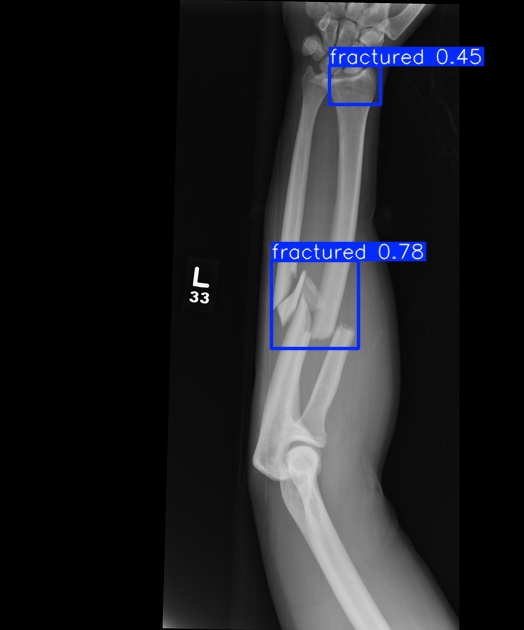

In [ ]:
from IPython.display import Image, display
import os

# Display the predicted image
display(Image(filename='/content/runs/detect/predict2/test_image2.jpg'))


In [ ]:
from PIL import Image
import os

# Load original image
original_img = Image.open("/content/test_image2.jpeg")

# Extract bounding boxes from results
for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        roi = original_img.crop((x1, y1, x2, y2))
        roi.save(f"crop_{i}.jpg")  # Save cropped ROI


##model Efficientnet B0

In [ ]:
import torchvision.transforms as transforms
from torchvision import models
import torch
from PIL import Image

# Load EfficientNet
model_effnet = models.efficientnet_b0(pretrained=True)
model_effnet.classifier[1] = torch.nn.Linear(in_features=1280, out_features=3)  # 3 classes for fracture types
model_effnet.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 71.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

##Transform

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
from PIL import Image
import torch

# Define your transform if not already defined
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts image to [C x H x W]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard for ImageNet
                         std=[0.229, 0.224, 0.225])
])

# Load and classify cropped regions
for i in range(len(boxes)):
    img = Image.open(f"crop_{i}.jpg").convert("RGB")  # ✅ Ensure RGB format
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model_effnet(input_tensor)
        predicted_class = output.argmax(1).item()
        print(f"Cropped ROI {i}: Predicted Fracture Type: {predicted_class}")


Cropped ROI 0: Predicted Fracture Type: 2
Cropped ROI 1: Predicted Fracture Type: 2


In [ ]:
label_map = {0: "Comminuted", 1: "Hairline", 2: "Simple"}
print(f"Fracture Type: {label_map[predicted_class]}")


Fracture Type: Simple


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image, ImageDraw, ImageFont
import numpy as np


In [ ]:
# Load original image
img_path = "/content/test_image2.jpeg"
original_img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(original_img)

# Load EfficientNet model
model_effnet = models.efficientnet_b0(pretrained=True)
model_effnet.classifier[1] = torch.nn.Linear(1280, 3)  # Adjust for your number of classes
model_effnet.eval()

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Define class labels
label_map = {0: "Comminuted", 1: "Hairline", 2: "Simple"}

# Predict on test image using YOLOv8
results = model.predict(source=img_path, save=False, conf=0.25)

# Extract bounding boxes and classify
for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)

        # Crop the ROI for classification
        roi = original_img.crop((x1, y1, x2, y2))
        input_tensor = transform(roi).unsqueeze(0)

        with torch.no_grad():
            output = model_effnet(input_tensor)
            predicted_class = output.argmax(1).item()
            label = label_map[predicted_class]

        # Draw bounding box and label
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1 - 10), label, fill="red")



image 1/1 /content/test_image2.jpeg: 800x672 2 fractureds, 20.5ms
Speed: 5.0ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 800, 672)


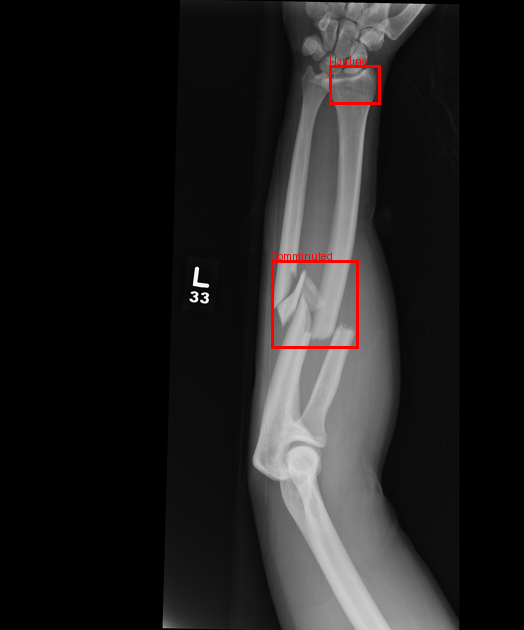

In [ ]:
display(original_img)


##REbuild

## Grad CAM Extension

In [ ]:
!pip install grad-cam --quiet
!pip install grad-cam timm opencv-python


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [ ]:
from torchvision import models

# Load trained EfficientNet
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(1280, 3)  # Assuming 3 classes: comminuted, hairline, simple
model.eval()

# Select target layer
target_layers = [model.features[-1]]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Load cropped image
img = Image.open("/content/crop_0.jpg").convert("RGB")  # your cropped region
rgb_img = np.array(img).astype(np.float32) / 255.0

# Transform for model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = transform(img).unsqueeze(0)


In [ ]:
with torch.no_grad():
    output = model(input_tensor)
    class_idx = output.argmax(1).item()
    print("Predicted class:", class_idx)


Predicted class: 1


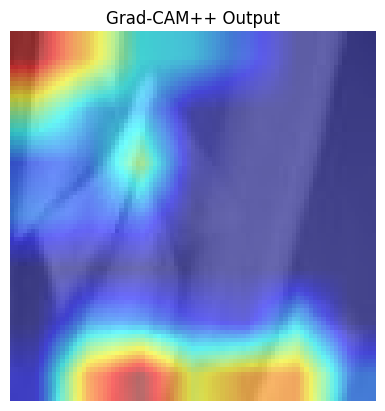

In [ ]:
import cv2
import numpy as np
from pytorch_grad_cam.utils.image import show_cam_on_image

# Resize grayscale_cam to match input image size (224x224)
grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))

# Overlay heatmap on RGB image
cam_image = show_cam_on_image(rgb_img, grayscale_cam_resized, use_rgb=True)

# Show the result
plt.imshow(cam_image)
plt.title("Grad-CAM++ Output")
plt.axis("off")
plt.show()


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


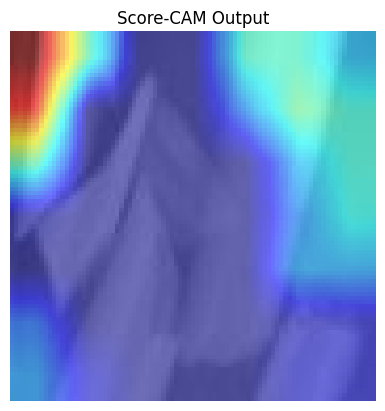

In [ ]:
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Initialize ScoreCAM
score_cam = ScoreCAM(model=model, target_layers=target_layers)

# Generate CAM
grayscale_score = score_cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(class_idx)])[0]

# Resize Score-CAM output to match input image size
grayscale_score_resized = cv2.resize(grayscale_score, (rgb_img.shape[1], rgb_img.shape[0]))

# Overlay on image
cam_img_score = show_cam_on_image(rgb_img, grayscale_score_resized, use_rgb=True)

# Show result
plt.imshow(cam_img_score)
plt.title("Score-CAM Output")
plt.axis("off")
plt.show()


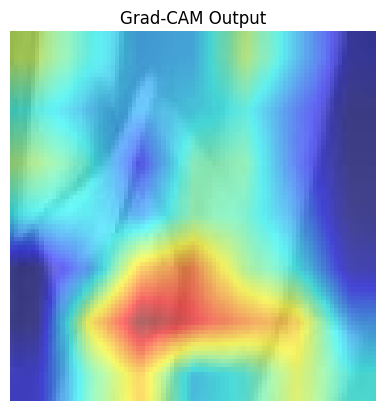

In [ ]:
from pytorch_grad_cam import GradCAM

# Initialize GradCAM
grad_cam = GradCAM(model=model, target_layers=target_layers)

# Generate CAM
grayscale_grad = grad_cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(class_idx)])[0]

# Resize output to match original image
grayscale_grad_resized = cv2.resize(grayscale_grad, (rgb_img.shape[1], rgb_img.shape[0]))

# Overlay CAM on image
cam_img_grad = show_cam_on_image(rgb_img, grayscale_grad_resized, use_rgb=True)

# Show result
plt.imshow(cam_img_grad)
plt.title("Grad-CAM Output")
plt.axis("off")
plt.show()


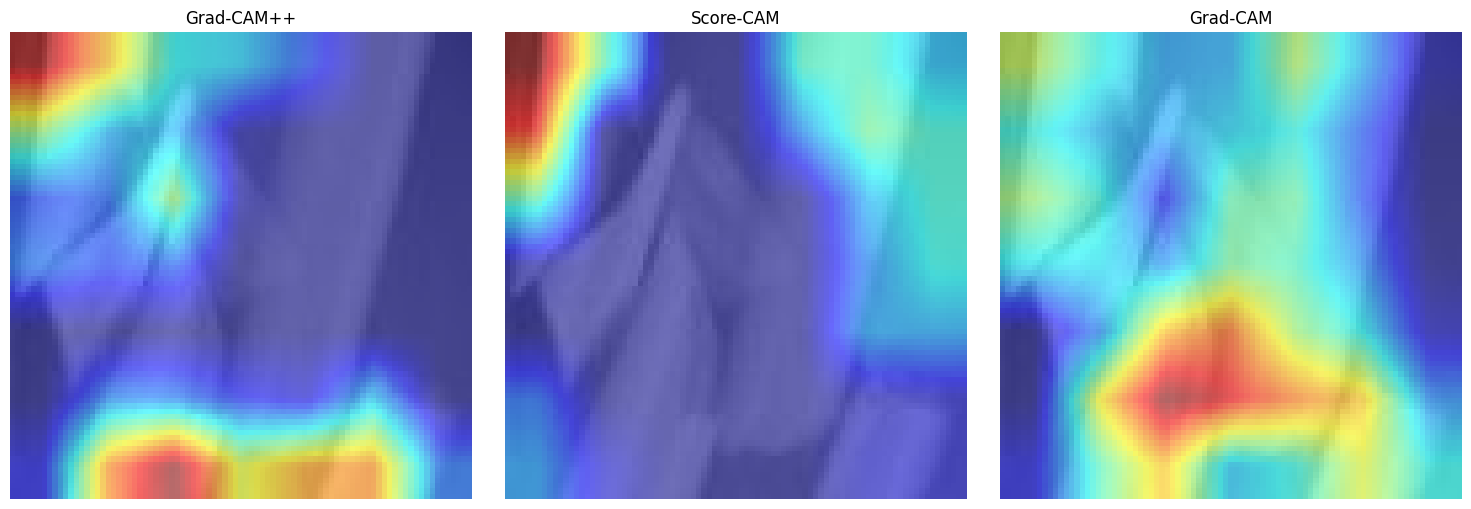

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(cam_image)  # Grad-CAM++
axs[0].set_title("Grad-CAM++")

axs[1].imshow(cam_img_score)  # Score-CAM
axs[1].set_title("Score-CAM")

axs[2].imshow(cam_img_grad)  # Grad-CAM
axs[2].set_title("Grad-CAM")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO
import torchvision.models as models

class HybridFractureModel(nn.Module):
    def __init__(self, yolo_path, effnet_path, num_classes=3):
        super(HybridFractureModel, self).__init__()

        # Load YOLOv8
        self.yolo = YOLO(yolo_path)

        # Load EfficientNetB0
        self.effnet = models.efficientnet_b0(pretrained=True)
        self.effnet.classifier[1] = nn.Linear(1280, num_classes)
        self.effnet.load_state_dict(torch.load(effnet_path, map_location='cpu'))
        self.effnet.eval()

    def forward(self, image):
        # Not implemented here: hybrid forward (YOLO detect -> crop -> classify)
        raise NotImplementedError("Use 'yolo' and 'effnet' modules individually for detection and classification.")

    def detect(self, image_path):
        return self.yolo(image_path)

    def classify(self, crop_tensor):
        with torch.no_grad():
            return self.effnet(crop_tensor)


In [ ]:
hybrid_model = HybridFractureModel(
    yolo_path="/content/yolov8_localization_fractureAtlas.pt",
    effnet_path="/content/efficientnet_classifier.pth"
)

# Save hybrid model
torch.save(hybrid_model, "/content/hybrid_fracture_model.pt")
print("✅ Hybrid model saved as 'hybrid_fracture_model.pt'")



✅ Hybrid model saved as 'hybrid_fracture_model.pt'


In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import models, transforms
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import numpy as np
import cv2
from PIL import Image

class HybridFractureModel(nn.Module):
    def __init__(self, yolo_path, effnet_path, num_classes=3):
        super(HybridFractureModel, self).__init__()

        # Load YOLOv8
        self.yolo = YOLO(yolo_path)

        # Load EfficientNetB0
        self.effnet = models.efficientnet_b0(pretrained=True)
        self.effnet.classifier[1] = nn.Linear(1280, num_classes)
        self.effnet.load_state_dict(torch.load(effnet_path, map_location='cpu'))
        self.effnet.eval()

        # Grad-CAM++
        self.target_layers = [self.effnet.features[-1]]
        self.cam = GradCAMPlusPlus(model=self.effnet, target_layers=self.target_layers)

        # Preprocessing transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def detect(self, image_path):
        return self.yolo(image_path)

    def classify(self, img_pil):
        tensor = self.transform(img_pil).unsqueeze(0)
        with torch.no_grad():
            output = self.effnet(tensor)
            pred = output.argmax(1).item()
        return pred, tensor

    def gradcam(self, img_pil, class_idx=None):
        img_rgb_np = np.array(img_pil).astype(np.float32) / 255.0
        tensor = self.transform(img_pil).unsqueeze(0)

        if class_idx is None:
            output = self.effnet(tensor)
            class_idx = output.argmax(1).item()

        grayscale_cam = self.cam(input_tensor=tensor,
                                 targets=[ClassifierOutputTarget(class_idx)])[0]
        grayscale_cam = cv2.resize(grayscale_cam, (224, 224))
        cam_image = show_cam_on_image(img_rgb_np, grayscale_cam, use_rgb=True)
        return cam_image, class_idx


In [ ]:
hybrid_model = HybridFractureModel(
    yolo_path="/content/yolov8_localization_fractureAtlas.pt",
    effnet_path="/content/efficientnet_classifier.pth"
)

torch.save(hybrid_model, "/content/hybrid_fracture_model_with_gradcam.pt")
print("✅ Hybrid model with Grad-CAM saved.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Hybrid model with Grad-CAM saved.


In [ ]:
# Load full hybrid model
hybrid_model_loaded = torch.load("/content/hybrid_fracture_model.pt", map_location='cpu')
hybrid_model_loaded.eval()

# You can now use:
# hybrid_model_loaded.detect(image_path)
# hybrid_model_loaded.classify(crop_tensor)
